# Fairness Checking: Statistical Parity Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [56]:
!pip install pulp

In [57]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import collections

In [58]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [59]:
pred_df = pd.read_csv('./../predicted_data/logreg_COMPAS.csv')

In [60]:
pred_df.head(5)

,Unnamed: 0,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction,prediction_prob
0,6055,1,23,0,0,0,0,2,0,1,0,1,0,0.450440
1,2925,1,28,1,0,0,0,0,0,0,1,0,0,0.285157
2,1353,1,25,0,0,0,0,0,0,1,0,0,0,0.295881
3,2144,1,53,1,0,0,0,1,0,0,1,0,0,0.066496
4,6062,1,30,0,0,0,0,4,1,1,0,1,1,0.582228


In [61]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [62]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [63]:
print(pi_0)
print(pi_1)

0.487012987012987
0.512987012987013


In [64]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = pred_df['prediction']
np.asarray(f_X)

array([0, 0, 0, ..., 1, 1, 1])

In [65]:
# Check if the dimensions match
print(len(f_X))
print(len(a_0_indices) + (len(a_1_indices)))

1232
1232


## Create Linear Program
We use the PuLP package to create our linear program.

Here, we allow another input for the upper bound on all w's. This must be a number between 0 and 1.

In [66]:
# Input: function f(X), constraint
# Output: (solved) model, weights
def SP_linear_prog(f_X, lower_bound, upper_bound):
  # Check if constraint is between 0 and 1
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint for the w's (experiment with this)
  for weight in w:
    model += w[weight] <= upper_bound
    model += w[weight] >= lower_bound

  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Constraints
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [67]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(1, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = SP_linear_prog(f_X, lower_bound, upper_bound)
  objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Constraint on w vs. SP LP Objective Value')

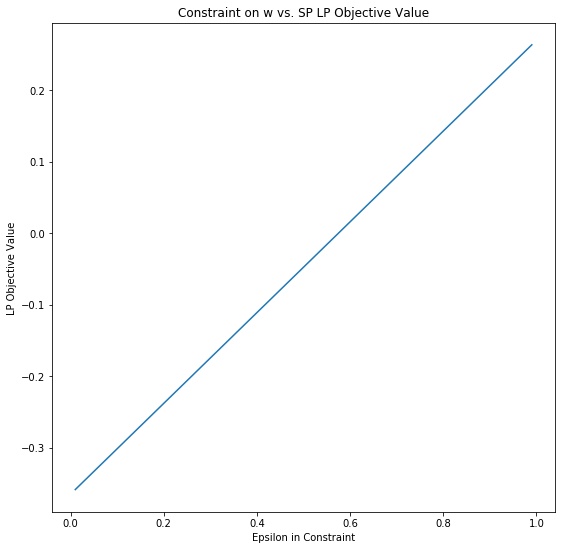

In [68]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, objective_values)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Constraint on w vs. SP LP Objective Value')

In [69]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

99
99


<BarContainer object of 1232 artists>

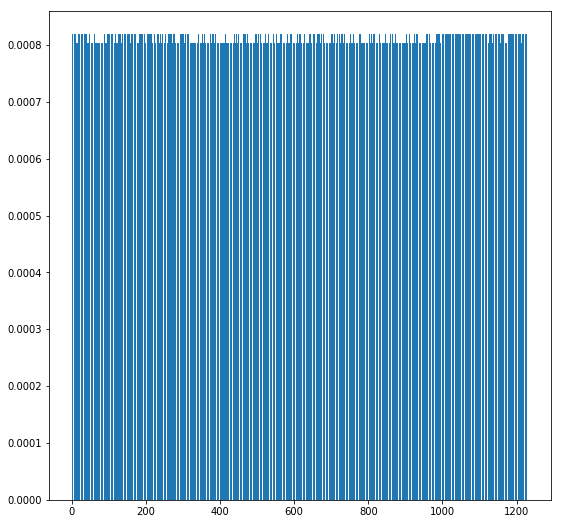

In [70]:
# Plot the distribution of weights
plt.figure(figsize=(9,9))
plt.bar(epsilon_to_weights[0.01].keys(), epsilon_to_weights[0.01].values())

In [71]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

1232
1232


## Marginal Distributions

In [72]:
pred_df['weights'] = epsilon_to_weights[0.9].values() # For example, when epsilon = 0.05
pred_df.head(5)

,Unnamed: 0,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction,prediction_prob,weights
0,6055,1,23,0,0,0,0,2,0,1,0,1,0,0.450440,0.001542
1,2925,1,28,1,0,0,0,0,0,0,1,0,0,0.285157,0.001542
2,1353,1,25,0,0,0,0,0,0,1,0,0,0,0.295881,0.001542
3,2144,1,53,1,0,0,0,1,0,0,1,0,0,0.066496,0.001542
4,6062,1,30,0,0,0,0,4,1,1,0,1,1,0.582228,0.001542


In [73]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [74]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{1: 0.8051948051948052, 0: 0.19480519480519481}
{0: 0.19480519572000007, 1: 0.8051948089760016}


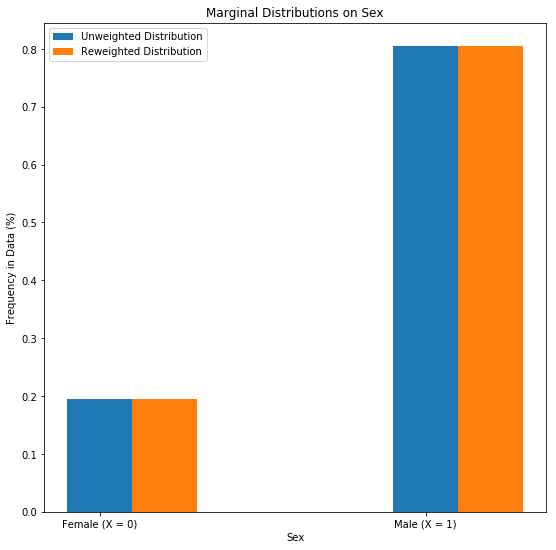

In [75]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [76]:
X_age_freq = freq_dict(pred_df, 'age')
X_age_marginal = marginalize(pred_df, 'age', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

In [77]:
X_age_freq

{27: 0.04707792207792208,
 25: 0.04626623376623377,
 22: 0.045454545454545456,
 21: 0.044642857142857144,
 28: 0.04383116883116883,
 24: 0.04383116883116883,
 26: 0.04301948051948052,
 29: 0.041396103896103896,
 23: 0.03977272727272727,
 30: 0.036525974025974024,
 31: 0.032467532467532464,
 32: 0.03165584415584415,
 34: 0.030844155844155844,
 20: 0.027597402597402596,
 37: 0.026785714285714284,
 33: 0.026785714285714284,
 38: 0.024350649350649352,
 43: 0.024350649350649352,
 36: 0.022727272727272728,
 35: 0.021915584415584416,
 39: 0.017045454545454544,
 40: 0.017045454545454544,
 47: 0.016233766233766232,
 44: 0.015422077922077922,
 45: 0.015422077922077922,
 42: 0.01461038961038961,
 52: 0.013798701298701298,
 50: 0.013798701298701298,
 56: 0.013798701298701298,
 57: 0.012987012987012988,
 46: 0.012987012987012988,
 41: 0.012987012987012988,
 54: 0.012987012987012988,
 53: 0.011363636363636364,
 48: 0.010551948051948052,
 59: 0.010551948051948052,
 49: 0.010551948051948052,
 51: 0.01

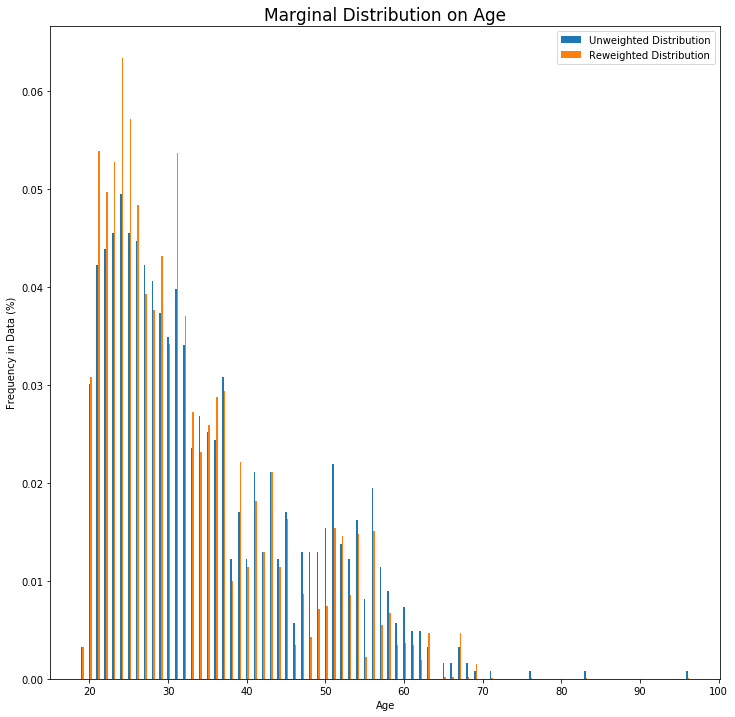

In [24]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age (SP Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.title("Marginal Distribution on Age", fontsize=17)
plt.show()

In [25]:
X_priors_freq = freq_dict(pred_df, 'priors_count')
X_priors_marginal = marginalize(pred_df, 'priors_count', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

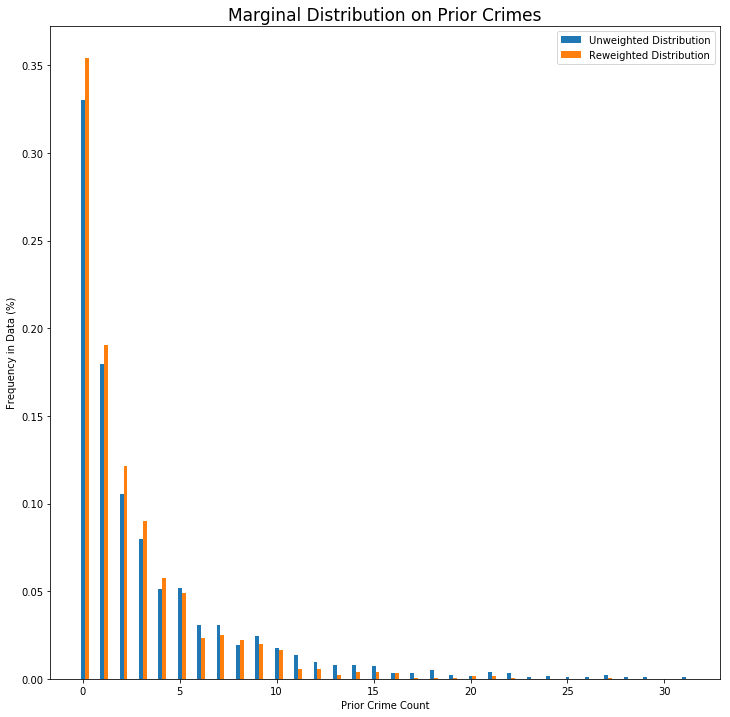

In [26]:
# Marginal Distribution on Prior Crimes 
X = np.asarray(list(X_priors_marginal.keys()))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes (SP Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Prior Crime Count')
plt.ylabel('Frequency in Data (%)')
plt.title("Marginal Distribution on Prior Crimes", fontsize=17)
plt.show()

In [27]:
X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

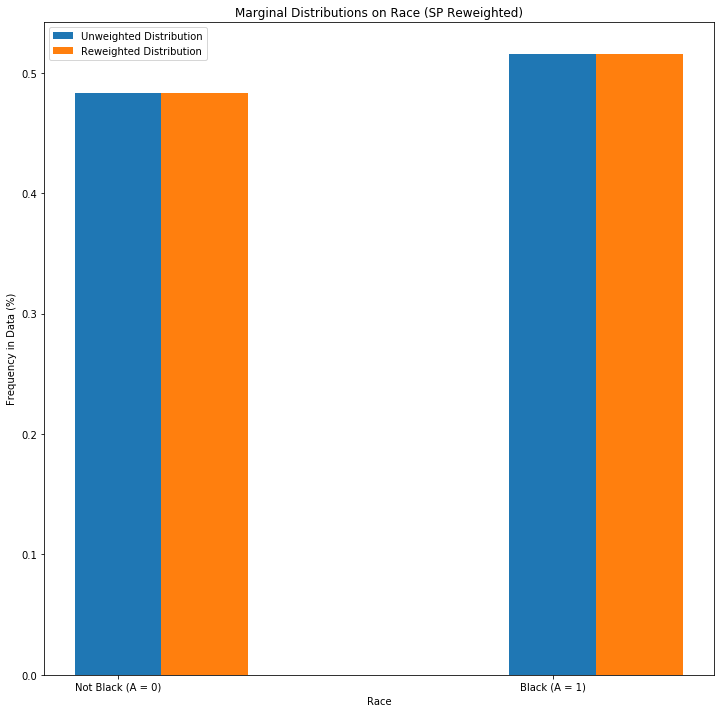

In [28]:
# Marginal Distribution on Race 
X = np.arange(len(X_race_freq))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Race (SP Reweighted)')
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Black (A = 0)', 'Black (A = 1)'])
plt.xlabel('Race')
plt.ylabel('Frequency in Data (%)')
plt.show()